# Analyse von Luftverschmutzungsdaten

## Daten
- Quelle: die [API](https://aqs.epa.gov/aqsweb/documents/data_api.html#lists) der EPA (US-Umweltbehörde)
- Luftverschmutzung Tagesdaten von Los Angeles von 2019 (Corona Jahre vernachlässigen)

In [1]:
'Import der Module'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as requests
import json
from time import sleep
import os
import seaborn as sns
from additional_functions import * 

'Load df'
df_pollutant=pd.read_csv("Pollution_Data/pollutant_df.csv",index_col=0)

'Define important Variables'

years=[2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2022]
#IDs for location
id={"la_n":1103,"pico_rivera":1602,"compton":1302,"signal_hill":4004}

#API Sign-Up
email="felixsch00@outlook.de"
#response_signup= requests.get(f"https://aqs.epa.gov/data/api/signup?email={email}")
#API Key via E-Mail
api_key="goldfox88" 
#Check if API is available --> 200 is working
response_available=requests.get("https://aqs.epa.gov/data/api/metaData/isAvailable")
print(f"Status Code Available: {response_available.status_code}")

Status Code Available: 200


In [21]:
'Get  some information about the parameters which can be requestet'
#Definitions
response_definition=requests.get(f"https://aqs.epa.gov/data/api/metaData/fieldsByService?email={email}&key={api_key}&service=sampleData")
print(f"Status Code E-Mail and Key okay: {response_definition.status_code}")

#Check available parameter classes (groups of parameter) -> to a JSON File
resp_parameter_classes=requests.get(f"https://aqs.epa.gov/data/api/list/classes?email={email}&key={api_key}")
with open("API_Infos/Parameter_Classes.json","w") as file:
    json.dump(resp_parameter_classes.json(),file,indent=4)
#Parameters from AQI POLLUTANTS   
def get_parameter_from_class(class_code:str,email=email,api_key=api_key):
    """Get the code and definition of available AQ Measurements, stores them in a JSON-File in API_Data Folder

    Args:
        class_code (str): Class Code shown in the Parameters_Classes.json file
        email (_type_, optional): For API. Defaults to email.
        api_key (_type_, optional): For API. Defaults to api_key.
    """
    parameters_api={"email":email,"key":api_key,"pc":class_code}
    req_parameters=requests.get("https://aqs.epa.gov/data/api/list/parametersByClass?",params=parameters_api)
    with open(f"API_Infos/Parameter_{class_code}.json","w") as file:
        json.dump(req_parameters.json(),file,indent=4)
    print(f"{class_code} Parameters successfully print to json file")
    return 

#Basic Pollutants
get_parameter_from_class("AQI POLLUTANTS")
#Meteorological Parameters
get_parameter_from_class("MET")
#Volatile organic compounds
get_parameter_from_class("VOC")



Status Code Available: 200
Status Code E-Mail and Key okay: 200
AQI POLLUTANTS Parameters successfully print to json file
MET Parameters successfully print to json file
VOC Parameters successfully print to json file


## Daten 

### API
AQS-API der US (EPA)[https://aqs.epa.gov/aqsweb/documents/data_api.html]

### Welche zeitliche Intervalle soll ich in meiner Analyse beobachten ?
- es können Daten bis zu den Messintervallen abgerufen werden (SampleData) -> damit könnte ich eigenen Intervalle (z.B. 6h) durch Mittelwertbildung berechnen
- einfacher ist es einfach die **täglichen Daten** Maxima zu betrachten (für eine genauere Betrachtung können ja auch die Mittelwerte betrachtet werden) --> Daily Summary Data by Site

### Messstadionen
- wichtig ist die Auswahl von drei zentral gelegenen Messstadionen. In einer [Kartenansicht](https://epa.maps.arcgis.com/apps/webappviewer/index.html?id=5f239fd3e72f424f98ef3d5def547eb5&extent=-146.2334,13.1913,-46.3896,56.5319) wurden diese ausgewählt.
    + Los Angeles-North Main Street (Short: LA_N): AQS Site ID 06-037-1103
    + Pico Rivera : AQS Site ID	06-037-1602
    + Compton: AQS Site ID	06-037-1302

![Die drei makierten Messstadionen wurden ausgesucht.](Stations_Map.png) 

### Parameter

In dem Codeblock oben wurden die allgemein verfügbaren Messsubstanzen in JSON Files geschrieben. 
Zu den spannenden Schadstoffen (inkl Code für API) zählt: 
- CO 42101
- SO2 42401
- NO2 42602
- O3 44201
- PM10 (Feinstaub) 81102 (0-10um gesamt)
- PM2.5 88101 
- (Total NMOC 43102 (alle VOC ohne CH4))

#### CO 42101
- verschiedene SampleDurations (1h und 8h) -> hier 1h verwenden
- Einheit: ppm
- Um fehlerhafte Messungen auszuschließen muss bei validity_indicator "Y" sein und observation_percentage > 40 % sein (eigene Festlegung)

#### NO2
- SampeDuration: "1 HOUR"
- Einheit: ppb

#### SO2
- Sample Duration: "5 MINUTE"
- Einheit: ppb

#### PM2.5
- SampleDuration: 24 Hour
- Max Hours ist immer 0 --> daher nur date and mean columns
- Einheit: microgram/m3
#### O3
- SampleDuration: "8-HR RUN AVG BEGIN HOUR"
- - Einheit: ppm

#### PM10
- SampleDuration: 24 HOUR bzw. teilweise alle 6 Tage
- bei dem gewählten Ort (Los Angeles North) oder Signal Hill  sind nur selten Messwerte vorhanden bzw. die Sample Duration passt schlecht zu den anderen Werten
- **dieser Schadstoff wird nicht berücksichtigt**

#### Umrechnung von ppb/ppm in Konzentration
- [Info dazu](https://www.unternehmensberatung-babel.de/berechnungen/umrechnung-ppm.php) wird für die AQI bestimmung benötigt
- $$ \beta_i = \frac{0.1 \cdot M \cdot p \cdot X_i \cdot 1000}{R \cdot T}
- M: Molmasse in g/mol
- p: Referenzdruck in mbar --> 1000
- X_i: Konzentration in ppm
- R: molare Gaskonstante: 8.314
- T: temperatur: 300 K
- beta_i: Konzentration in microgram/m3
### AirQualityIndex (AQI)

- siehe https://www.eea.europa.eu/themes/air/air-quality-index -> bei About the Eu Air Q Index in der Kartenlegende
- **wichtig: Werte müssen in microgram/m3 gegeben sein**
!(Eigenes_Projekt/Dokumentation/AQI_index_Bedeutung.png)
!(Eigenes_Projekt/Dokumentation/AQI_index_Tabelle.png)

In [4]:

parameter_pollutant={"CO":42101,"SO2": 42401,"NO2": 42602 ,"O3" :44201,"PM10" : 81102,"PM2.5":88101}


for year in years:
    for parameter in parameter_pollutant.values():
        get_epa_data(parameter,year,site=id["la_n"],folder="Pollution_Data/raw")
        #additional data for pm10 at another station
        get_epa_data(parameter_pollutant["PM10"],year,site=4004,folder="Pollution_Data/raw")

Already exists: Year: 2010, Parameter: 42101, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2010, Parameter: 42401, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2010, Parameter: 42602, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2010, Parameter: 44201, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2010, Parameter: 81102, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2010, Parameter: 88101, Site: 1103
Already exists: Year: 2010, Parameter: 81102, Site: 4004
Already exists: Year: 2011, Parameter: 42101, Site: 1103
Already exists: Year: 2011, Parameter: 81102, Site: 4004
Already exists: Year: 2011, Parameter: 42401, Site: 1103
Already exists: Year: 2011, Parameter: 81102, Site: 4004
Already exists: Year: 2011, Parameter: 42602, Site: 1103
Already exists: Year: 2011, Par

In [5]:
"Concat  json Pollution files to one large file per different pollution. "
# if Error occurs run the cell above
# 88101 is PM2.5
for parameter in [88101]:
    all_df=[]
    for year in years:
        path = get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Pollution_Data/raw")
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_df.append(df_single_year)
    
    df_pm2_5=pd.DataFrame()
    df_pm2_5=pd.concat(all_df)

print(df_pm2_5.shape)
df_pm2_5=df_pm2_5[df_pm2_5["validity_indicator"]=="Y"]
df_pm2_5=df_pm2_5[df_pm2_5["observation_percent"]>50]
print(df_pm2_5.shape)
df_pm2_5["date"] = pd.to_datetime(df_pm2_5["date_local"],format="%Y-%m-%d")
#print(df_pm2_5.describe())
df_pm2_5.drop(labels=["first_max_value","first_max_hour","sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
df_pm2_5.columns = ["mean_pm2_5","date"]
df_pm2_5=df_pm2_5.groupby(["date"]).mean()
df_pm2_5.info()
df_pm2_5.head(10)
df_pm2_5.info()
df_pm2_5.head(5)


(2328, 32)
(2286, 32)
(2376, 32)
(2412, 32)
(828, 32)
(2382, 32)
(2466, 32)
(2514, 32)
(2436, 32)
(2508, 32)
(1242, 32)
(23778, 8)
(23778, 8)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3414 entries, 2010-01-01 to 2022-06-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  3414 non-null   float64
dtypes: float64(1)
memory usage: 53.3 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3414 entries, 2010-01-01 to 2022-06-30
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   mean_pm2_5  3414 non-null   float64
dtypes: float64(1)
memory usage: 53.3 KB


,mean_pm2_5
date,
2010-01-01,13.1
2010-01-02,6.3
2010-01-03,4.9
2010-01-04,6.1
2010-01-05,7.8


In [6]:
"Concat json Pollution files to one large file per different pollution. The Result will be stored as df in the all_pollutants list (except pm2.5 which is processed above seperatly)"
all_pollutants=[]
for key,parameter in {"co":42101,"so2": 42401,"no2": 42602 ,"o3" :44201}.items():
    all_years=[]
    print(key)
    print(parameter)
    for year in years:
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Pollution_Data/raw")
        with open(path) as file:
            data=json.load(file)
        
        df_single_year=pd.json_normalize(data["Data"])
        print(df_single_year.shape)
        df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                        "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                        "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                        "aqi"]
                ,axis=1,inplace=True)
        all_years.append(df_single_year)
    
    
    df_single_pollutant=pd.DataFrame()
    df_single_pollutant=pd.concat(all_years)

    print(df_single_pollutant.shape)
    df_single_pollutant=df_single_pollutant[df_single_pollutant["validity_indicator"]=="Y"]
    df_single_pollutant=df_single_pollutant[df_single_pollutant["observation_percent"]>50]
    print(df_single_pollutant.shape)
    df_single_pollutant["date"] = pd.to_datetime(df_single_pollutant["date_local"],format="%Y-%m-%d")
    #print(df_single_pollutant.describe())
    df_single_pollutant.drop(labels=["sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
    print(df_single_pollutant.columns)
    df_single_pollutant.columns = [f"mean_{key}",f"max_value_{key}",f"max_hour_{key}","date"]
    df_single_pollutant=df_single_pollutant.groupby(["date"]).agg({f"mean_{key}":"mean",f"max_value_{key}":"max",f"max_hour_{key}":"mean"})
    df_single_pollutant[f"max_hour_{key}"]=np.round(df_single_pollutant[f"max_hour_{key}"])
    df_single_pollutant[f"max_hour_{key}"]=df_single_pollutant[f"max_hour_{key}"].astype("int8")
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    df_single_pollutant.info()
    df_single_pollutant.head(10)
    all_pollutants.append(df_single_pollutant)


co
42101
(728, 32)
(897, 32)
(1067, 32)
(1447, 32)
(1453, 32)
(1096, 32)
(1365, 32)
(1381, 32)
(1247, 32)
(1014, 32)
(1084, 32)
(12779, 8)
(12589, 8)
Index(['arithmetic_mean', 'first_max_value', 'first_max_hour', 'date'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2010-01-01 to 2022-09-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       3914 non-null   float64
 1   max_value_co  3914 non-null   float64
 2   max_hour_co   3914 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 95.6 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3914 entries, 2010-01-01 to 2022-09-30
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mean_co       3914 non-null   float64
 1   max_value_co  3914 non-null   float64
 2   max_hour_co   3914 non-null   int8   
dtypes: float64(2), int8(1)
memory

In [23]:
'Fügt alle Werte zusammen'
df_pollutant=pd.concat([*all_pollutants,df_pm2_5],axis=1)
df_pollutant[["mean_co","max_value_co"]]= change_pollution_unit(df_pollutant[["mean_co","max_value_co"]],"ppm","co")
df_pollutant[["mean_so2","max_value_so2"]]= change_pollution_unit(df_pollutant[["mean_so2","max_value_so2"]],"ppb","so2")
df_pollutant[["mean_no2","max_value_no2"]]= change_pollution_unit(df_pollutant[["mean_no2","max_value_no2"]],"ppb","no2")
df_pollutant[["mean_o3","max_value_o3"]]= change_pollution_unit(df_pollutant[["mean_o3","max_value_o3"]],"ppm","o3")
df_pollutant = df_pollutant.round(1)
df_pollutant.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3924 entries, 2010-01-01 to 2022-09-30
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   mean_co        3914 non-null   float64
 1   max_value_co   3914 non-null   float64
 2   max_hour_co    3914 non-null   float64
 3   mean_so2       3566 non-null   float64
 4   max_value_so2  3566 non-null   float64
 5   max_hour_so2   3566 non-null   float64
 6   mean_no2       3630 non-null   float64
 7   max_value_no2  3630 non-null   float64
 8   max_hour_no2   3630 non-null   float64
 9   mean_o3        3777 non-null   float64
 10  max_value_o3   3777 non-null   float64
 11  max_hour_o3    3777 non-null   float64
 12  mean_pm2_5     3414 non-null   float64
dtypes: float64(13)
memory usage: 429.2 KB


In [47]:
#add AQI for each Pollutant based on max_value
aqi_string=pd.CategoricalDtype(["Good","Fair","Moderate","Poor","Very Poor","Extremely Poor"],ordered=True)
df_pollutant.loc[df_pollutant["mean_pm2_5"]>=75,"aqi_pm2_5"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<75,"aqi_pm2_5"] = "Very Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<50,"aqi_pm2_5"] = "Poor"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<25,"aqi_pm2_5"] = "Moderate"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<20,"aqi_pm2_5"] = "Fair"
df_pollutant.loc[df_pollutant["mean_pm2_5"]<10,"aqi_pm2_5"] = "Good"
df_pollutant["aqi_pm2_5"] = df_pollutant["aqi_pm2_5"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_so2"]>=750,"aqi_so2"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<750,"aqi_so2"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<500,"aqi_so2"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_so2"]<350,"aqi_so2"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_so2"]<200,"aqi_so2"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_so2"]<100,"aqi_so2"] = "Good"
df_pollutant["aqi_so2"] = df_pollutant["aqi_so2"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_no2"]>=340,"aqi_no2"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<340,"aqi_no2"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<230,"aqi_no2"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_no2"]<120,"aqi_no2"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_no2"]<90,"aqi_no2"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_no2"]<40,"aqi_no2"] = "Good"
df_pollutant["aqi_no2"] = df_pollutant["aqi_no2"].astype(aqi_string)

df_pollutant.loc[df_pollutant["max_value_o3"]>=380,"aqi_o3"] = "Extremely Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<380,"aqi_o3"] = "Very Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<240,"aqi_o3"] = "Poor"
df_pollutant.loc[df_pollutant["max_value_o3"]<130,"aqi_o3"] = "Moderate"
df_pollutant.loc[df_pollutant["max_value_o3"]<100,"aqi_o3"] = "Fair"
df_pollutant.loc[df_pollutant["max_value_o3"]<50,"aqi_o3"] = "Good"
df_pollutant["aqi_o3"] = df_pollutant["aqi_o3"].astype(aqi_string)

In [77]:
# find the max aqi column
aqi_skala={"Good":0,"Fair":1,"Moderate":2,"Poor":3,"Very Poor":4,"Extremely Poor":5}
pollutant_aqi=df_pollutant[["aqi_no2","aqi_o3","aqi_so2","aqi_pm2_5"]]
for column in pollutant_aqi.columns:
    pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)

pollutant_aqi = pollutant_aqi.astype(np.float64)

df_pollutant["aqi_idxmax"]=pollutant_aqi.idxmax(axis=1)
df_pollutant["aqi_max"] = pollutant_aqi.max(axis=1).astype(pd.CategoricalDtype([1,2,3,4,5],ordered=True))
df_pollutant["aqi_max"] = df_pollutant["aqi_max"].cat.rename_categories({value:key for key,value in aqi_skala.items()})
df_pollutant["aqi_max"]

/tmp/ipykernel_5814/2097161038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)
/tmp/ipykernel_5814/2097161038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pollutant_aqi[column] = pollutant_aqi[column].cat.rename_categories(aqi_skala)
/tmp/ipykernel_5814/2097161038.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

date
2010-01-01        Fair
2010-01-02        Fair
2010-01-03        Fair
2010-01-04        Fair
2010-01-05        Fair
                ...   
2022-09-26        Poor
2022-09-27        Poor
2022-09-28        Poor
2022-09-29    Moderate
2022-09-30    Moderate
Name: aqi_max, Length: 3924, dtype: category
Categories (5, object): ['Fair' < 'Moderate' < 'Poor' < 'Very Poor' < 'Extremely Poor']

In [78]:
df_pollutant.to_hdf("Pollution_Data/pollutant_data.h5","data",format="table")

## Daten zur Vorhersage der Schadstoffe

### Meterologische Daten aus der AQS API der EPA


Die folgenden Parameter werden abgerufen: 
- Wind-Geschwindigkeit (in Knoten)
- Wind-Richtung (beides vektoriell, auch als Resultant bezeichnet) (in Grad Kompass)
- Temperatur (raw: Fahrenheit -> Celsius) 
- Tempertur max 
- Feuchtigkeit (in %) + max
- Solar radiation (langleys/minute)
- UV radiation  (")
- barometric pressure (in mbar)

Gut wären außerdem noch (an Stadion nicht verfügbar):
- min T 62105 -> NOAA 
- differenz min max T 62106 oder selbst berechnen -> NOAA
- visibility 63101
- rain 65101 -> NOAA
- Cloud cover 66101

vieleicht hier zu finden (https://www.ncdc.noaa.gov/cdo-web/webservices)

### Kalenderdaten
- Wochentag
- Monat

In [3]:
meterologic_parameter={"wind_speed":61103 , "wind_direction":61104, "temp":62101,
                       "humidity":62201,"radiation":63301, "uv_radiation": 63302,
                       "pressure":64101}

site_la_north=1103

for year in years:
    for parameter in meterologic_parameter.values(): 
        get_epa_data(parameter,year,site_la_north,folder="Predictor_Data/raw_aqs")

Request Empty
Request Empty
Already exists: Year: 2010, Parameter: 62101, Site: 1103
Already exists: Year: 2010, Parameter: 62201, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2010, Parameter: 64101, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2011, Parameter: 62101, Site: 1103
Already exists: Year: 2011, Parameter: 62201, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2011, Parameter: 64101, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2012, Parameter: 62101, Site: 1103
Already exists: Year: 2012, Parameter: 62201, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2012, Parameter: 64101, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2013, Parameter: 62101, Site: 1103
Already exists: Year: 2013, Parameter: 62201, Site: 1103
Request Empty
Request Empty
Already exists: Year: 2013, Parameter: 64101, Site: 1103
Already exists: Year: 2014, Parameter: 61103, Site: 1103
Already exists: Year: 2014, Paramet

In [4]:
'Concat the meterologic_parameter'
all_meterologic_parameter=[]
for key,parameter in meterologic_parameter.items():
    all_years=[]
    print(key)
    print(parameter)
    for year in years:
        print(year)
        path=get_epa_data(parameter,year,id["la_n"],only_get_path=True,folder="Predictor_Data/raw_aqs")
        try:
            with open(path) as file:
                data=json.load(file)
            
            df_single_year=pd.json_normalize(data["Data"])
            print(df_single_year.shape)
            df_single_year.drop(labels=["site_number","parameter_code","state_code","county_code","poc","latitude","longitude","datum","parameter","sample_duration_code",
                            "pollutant_standard","units_of_measure","event_type","method_code","method","local_site_name",
                            "site_address","state", "county","city","cbsa_code","cbsa","date_of_last_change",
                            "aqi"]
                    ,axis=1,inplace=True)
            all_years.append(df_single_year)
        except:
            print("File not available")
        
    single_meterologic_parameter=pd.DataFrame()
    single_meterologic_parameter=pd.concat(all_years)

    print(single_meterologic_parameter.shape)
    single_meterologic_parameter=single_meterologic_parameter[single_meterologic_parameter["validity_indicator"]=="Y"]
    single_meterologic_parameter=single_meterologic_parameter[single_meterologic_parameter["observation_percent"]>40]
    print(single_meterologic_parameter.shape)
    single_meterologic_parameter["date"] = pd.to_datetime(single_meterologic_parameter["date_local"],format="%Y-%m-%d")
    #print(single_meterologic_parameter.describe())
    single_meterologic_parameter.drop(labels=["sample_duration","date_local","observation_percent","validity_indicator","observation_count"],inplace=True,axis=1)
    print(single_meterologic_parameter.columns)
    single_meterologic_parameter.columns = [f"mean_{key}",f"max_value_{key}",f"max_hour_{key}","date"]
    single_meterologic_parameter=single_meterologic_parameter.groupby(["date"]).agg({f"mean_{key}":"mean",f"max_value_{key}":"max",f"max_hour_{key}":"mean"})
    single_meterologic_parameter[f"max_hour_{key}"]=np.round(single_meterologic_parameter[f"max_hour_{key}"])
    single_meterologic_parameter[f"max_hour_{key}"]=single_meterologic_parameter[f"max_hour_{key}"].astype("int8")
    single_meterologic_parameter.info()
    single_meterologic_parameter.head(10)
    single_meterologic_parameter.info()
    single_meterologic_parameter.head(10)
    all_meterologic_parameter.append(single_meterologic_parameter)

all_meterologic_parameter = pd.concat(all_meterologic_parameter,axis=1)
#change Unit from fahrenheit to celsius 
all_meterologic_parameter[["max_value_temp","mean_temp"]] = (all_meterologic_parameter[["max_value_temp","mean_temp"]] -32 ) * 5/9
all_meterologic_parameter.info()
all_meterologic_parameter.to_csv("Predictor_Data/meterologic_parameter.csv")
all_meterologic_parameter.head(10)

wind_speed
61103
2010
File not available
2011
File not available
2012
File not available
2013
File not available
2014
(365, 32)
2015
(87, 32)
2016
(275, 32)
2017
(365, 32)
2018
(365, 32)
2019
(365, 32)
2022
File not available
(1822, 8)
(1812, 8)
Index(['arithmetic_mean', 'first_max_value', 'first_max_hour', 'date'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1812 entries, 2014-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_wind_speed       1812 non-null   float64
 1   max_value_wind_speed  1812 non-null   float64
 2   max_hour_wind_speed   1812 non-null   int8   
dtypes: float64(2), int8(1)
memory usage: 44.2 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1812 entries, 2014-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mean_w

,mean_wind_speed,max_value_wind_speed,max_hour_wind_speed,mean_wind_direction,max_value_wind_direction,max_hour_wind_direction,mean_temp,max_value_temp,max_hour_temp,mean_humidity,...,max_hour_humidity,mean_radiation,max_value_radiation,max_hour_radiation,mean_uv_radiation,max_value_uv_radiation,max_hour_uv_radiation,mean_pressure,max_value_pressure,max_hour_pressure
date,,,,,,,,,,,,,,,,,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN,NaN,15.046296,22.777778,11.0,45.375000,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1009.083333,1014.0,10.0
2010-01-02,NaN,NaN,NaN,NaN,NaN,NaN,18.171296,28.333333,13.0,37.750000,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,1005.125000,1009.0,10.0
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN,18.055556,27.777778,13.0,28.208333,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1005.375000,1008.0,9.0
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,17.129629,26.111111,14.0,27.791667,...,21.0,NaN,NaN,NaN,NaN,NaN,NaN,1005.458333,1008.0,9.0
2010-01-05,NaN,NaN,NaN,NaN,NaN,NaN,16.921296,28.333333,13.0,32.916667,...,23.0,NaN,NaN,NaN,NaN,NaN,NaN,1005.041667,1009.0,10.0
2010-01-06,NaN,NaN,NaN,NaN,NaN,NaN,16.250000,25.555556,12.0,45.291667,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,1004.208333,1008.0,9.0
2010-01-07,NaN,NaN,NaN,NaN,NaN,NaN,15.601852,26.111111,12.0,53.416667,...,19.0,NaN,NaN,NaN,NaN,NaN,NaN,1003.125000,1007.0,10.0
2010-01-08,NaN,NaN,NaN,NaN,NaN,NaN,18.148148,27.777778,13.0,46.041667,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1006.125000,1009.0,9.0
2010-01-09,NaN,NaN,NaN,NaN,NaN,NaN,18.495371,26.111111,14.0,38.416667,...,7.0,NaN,NaN,NaN,NaN,NaN,NaN,1007.625000,1011.0,10.0


In [9]:
all_meterologic_parameter["mean_wind_direction"]

date
2010-01-01           NaN
2010-01-02           NaN
2010-01-03           NaN
2010-01-04           NaN
2010-01-05           NaN
                 ...    
2019-12-27     84.875000
2019-12-28     79.375000
2019-12-29     76.958333
2019-12-30    103.666667
2019-12-31     98.875000
Name: mean_wind_direction, Length: 3189, dtype: float64

In [10]:
def get_direction(degree):
    """ Gibt die Himmelsrichtung des Windes wieder, statt des Angabe in Grad."""
    if np.isnan(degree):
        return np.nan
    elif degree >=45 and degree <135:
        return "west"
    elif degree >=135 and degree <225:
        return "south"
    elif degree >=225 and degree <315:
        return "east"
    elif degree >=315 and degree <45:
        return "north"
    else:
        return np.nan

#umwandeln der windrichtung von grad in Himmelsrichtungen
all_meterologic_parameter["mean_wind_direction"]=(all_meterologic_parameter["mean_wind_direction"].map(get_direction)).astype(pd.CategoricalDtype(categories=["north","south","east","west"]))
all_meterologic_parameter["mean_wind_direction"].value_counts()

south    1016
west      482
east      310
north       0
Name: mean_wind_direction, dtype: int64

In [36]:
# all not available at La_N and other stations in La
parameter_test=[62105,62106,63101,65102,66101,61105,61106,61120,61202,62108,62604,63303,63304,63305,65101,65103]

for year in [2019]:
    for parameter in parameter_test:
        print(parameter)
        get_epa_data(parameter,year,1302,folder="Predictor_Data/raw_aqs")

62105
Request Empty
62106
Request Empty
63101
Request Empty
65102
Request Empty
66101
Request Empty
61105
Request Empty
61106
Request Empty
61120
Request Empty
61202
Request Empty
62108
Request Empty
62604
Request Empty
63303
Request Empty
63304
Request Empty
63305
Request Empty
65101
Request Empty
65103
Request Empty


### Daten zum Stromverbrauch 
Daten aus der API der EIA und beziehen sich auf das ganze County Los Angeles in einer täglichen Basis. Dabei sind leider nur die Daten ab Mitte 2015 verfügbar. 
- demand: in MWh
- net_generation: in MWh  

Die URL zum API Request wurde dabei in einem [Online-Tool](https://www.eia.gov/opendata/browser/) erstellt.

In [37]:
'Load the electricity data from EIA API'
'Note: The request string is constructed online via an interface'
eia_apikey="ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e"
"api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&"
#reguest the net generation of electricity in the LA region
req_net_generation=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[type][]=NG&facets[respondent][]=LDWP&facets[timezone][]=Pacific&start=2015-06-30&end=2022-12-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
req_demand=requests.get("https://api.eia.gov/v2/electricity/rto/daily-region-data/data/?api_key=ji4rAKmmenbLRssSzeJ98DoW2Gf76lrXkmWHyK2e&frequency=daily&data[0]=value&facets[respondent][]=LDWP&facets[timezone][]=Pacific&facets[type][]=D&start=2015-06-30&end=2022-12-01&sort[0][column]=period&sort[0][direction]=desc&offset=0&length=5000")
with open("Predictor_Data/electricity_net_generation.json","w") as file:
                json.dump(req_net_generation.json(),file,indent=4)
with open("Predictor_Data/electricity_demand.json","w") as file:
                json.dump(req_demand.json(),file,indent=4)

/home/felix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


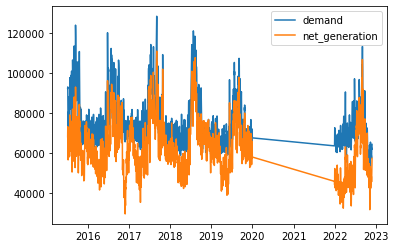

In [15]:
with open("Predictor_Data/electricity_demand.json") as file:
    electricity_demand=pd.json_normalize(json.load(file)["response"]["data"])
    
with open("Predictor_Data/electricity_net_generation.json") as file:
    electricity_net_generation=pd.json_normalize(json.load(file)["response"]["data"])

#change columnames and make date column
electricity_demand["demand_electricity"]=electricity_demand["value"]
electricity_net_generation["net_generation_electricity"]=electricity_net_generation["value"]
electricity_demand["date"]=pd.to_datetime(electricity_demand["period"],format="%Y-%m-%d")
electricity_net_generation["date"]=pd.to_datetime(electricity_net_generation["period"],format="%Y-%m-%d")

# delete other columns and set date as index
electricity_demand=electricity_demand[["date","demand_electricity"]].set_index("date")
electricity_net_generation=electricity_net_generation[["date","net_generation_electricity"]].set_index("date")


electricity=pd.concat([electricity_demand,electricity_net_generation],axis=1)

#delete year 2020,2021
electricity = electricity.drop(pd.date_range(start='01/01/2020', end='31/12/2021'),errors="ignore")
electricity.to_csv("Predictor_Data/electricity.csv")

plt.plot(electricity.index,electricity["demand_electricity"],label="demand")
plt.plot(electricity.index,electricity["net_generation_electricity"],label="net_generation")
plt.legend()

### Wetter Daten 
Um weitere Wetter Daten zu erhaten wird auf die Daten der [NOAA](https://www.ncei.noaa.gov/cdo-web/search?datasetid=GHCND) zurückgegriffen. Dabei werden die Daily Summary Daten online als .csv abgerufen. 
- rain in mm/m²
- t_max in °C
- t_min in °C
- t_minmax als berechnete Differenz zwischen den beiden Werten  
  
Die Daten sind hier ab 2010 bis 2020 abgerufen.

In [33]:
# load the csv File and process it 
weather=pd.read_csv("Predictor_Data/weather_raw.csv")
weather=weather[["DATE","PRCP","TMAX","TMIN"]]
#load the extra data from 2022
weather_2022=pd.read_csv("Predictor_Data/weather_raw_2022.csv")
weather_2022= weather_2022[weather_2022["STATION"]=="USW00093134"]
weather_2022=weather_2022[["DATE","PRCP","TMAX","TMIN"]]
weather=pd.concat([weather,weather_2022])
weather["DATE"] = pd.to_datetime(weather["DATE"],format="%Y-%m-%d")
weather=weather.set_index("DATE")
weather.columns = ["rain","t_max","t_min"]

#Rain as Boolean
def rain_bool(rain_value):
    if np.isnan(rain_value):
        return False
    elif rain_value>0:
        return True
    else: 
        return False
    
weather["rain_bool"]= weather["rain"].map(rain_bool).astype(bool)

#new columns
weather["t_minmax"]=weather["t_max"]-weather["t_min"]
weather.to_csv("Predictor_Data/weather.csv")
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3994 entries, 2010-01-01 to 2022-12-08
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rain       3994 non-null   float64
 1   t_max      3994 non-null   float64
 2   t_min      3994 non-null   float64
 3   rain_bool  3994 non-null   bool   
 4   t_minmax   3994 non-null   float64
dtypes: bool(1), float64(4)
memory usage: 159.9 KB


In [26]:
'Kalenderdaten'
date_range = pd.date_range("01/01/2010",end="31/12/2022")
kalender=pd.DataFrame(index=date_range,data={"day_of_week":(date_range.day_of_week +1),
                                             "month":date_range.month,
                                             "quarter":date_range.quarter,
                                             "year":date_range.year})

def check_business_day(day_of_week):
    if day_of_week>5:
        return False
    elif day_of_week<=5:
        return True

kalender["business_day"]=kalender["day_of_week"].map(check_business_day)
kalender = kalender.drop(pd.date_range(start='01/01/2020', end='31/12/2021'),errors="ignore")
kalender.info()
kalender.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2010-01-01 to 2022-12-31
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   day_of_week   4017 non-null   int64
 1   month         4017 non-null   int64
 2   quarter       4017 non-null   int64
 3   year          4017 non-null   int64
 4   business_day  4017 non-null   bool 
dtypes: bool(1), int64(4)
memory usage: 160.8 KB


/home/felix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/felix/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3369: UserWarning: Parsing '31/12/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


,day_of_week,month,quarter,year,business_day
2010-01-01,5,1,1,2010,True
2010-01-02,6,1,1,2010,False
2010-01-03,7,1,1,2010,False
2010-01-04,1,1,1,2010,True
2010-01-05,2,1,1,2010,True


In [37]:
'Encoding mit dem Mittelwert in Boolesche Werte'
# Falls der numerische Wert über dem Mittelwert liegt ist der Wert True, sonst False
def mean_encoding(df_column):
    mean_column=df_column.mean()
    df_column = (df_column.map(lambda x: True if x>mean_column else False)).astype(bool)
    return df_column



In [47]:
df_predictor.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4017 entries, 2010-01-01 to 2022-12-31
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   mean_wind_speed             1812 non-null   float64 
 1   max_value_wind_speed        1812 non-null   float64 
 2   max_hour_wind_speed         1812 non-null   float64 
 3   mean_wind_direction         1808 non-null   category
 4   max_value_wind_direction    1812 non-null   float64 
 5   max_hour_wind_direction     1812 non-null   float64 
 6   mean_temp                   3084 non-null   float64 
 7   max_value_temp              3084 non-null   float64 
 8   max_hour_temp               3084 non-null   float64 
 9   mean_humidity               3080 non-null   float64 
 10  max_value_humidity          3080 non-null   float64 
 11  max_hour_humidity           3080 non-null   float64 
 12  mean_radiation              1793 non-null   float64 
 13  

In [46]:
'Zusammenfügen aller Dataframes zur Vorhersage'
df_predictor=pd.concat([all_meterologic_parameter,weather,electricity,kalender],axis=1)
df_predictor["rain_bool"]=df_predictor["rain_bool"].astype(bool)
df_predictor["temp_bool"]=mean_encoding(df_predictor["mean_temp"])
df_predictor["wind_bool"]=mean_encoding(df_predictor["mean_wind_speed"])
df_predictor["humidity_bool"]=mean_encoding(df_predictor["mean_humidity"])
df_predictor["radiation_bool"]=mean_encoding(df_predictor["mean_radiation"])
df_predictor["tminmax_bool"]=mean_encoding(df_predictor["t_minmax"])
(df_predictor.dropna())["wind_bool"].value_counts()

#df_predictor.info()
#df_predictor.to_csv("Predictor_Data/all.csv",index_label="date")


False    741
True     574
Name: wind_bool, dtype: int64

In [48]:
df_predictor.to_hdf("Predictor_Data/all.h5","data",format="table")
df_notnan= df_predictor.dropna()
print(f"Columns without Nan: {df_notnan.shape[0]} ")
df_notnan.head()

Columns without Nan: 1315 


,mean_wind_speed,max_value_wind_speed,max_hour_wind_speed,mean_wind_direction,max_value_wind_direction,max_hour_wind_direction,mean_temp,max_value_temp,max_hour_temp,mean_humidity,...,day_of_week,month,quarter,year,business_day,temp_bool,wind_bool,humidity_bool,radiation_bool,tminmax_bool
2016-04-01,3.912500,7.1,15.0,south,263.0,18.0,16.363426,21.555556,12.0,63.250000,...,5,4,2,2016,True,False,True,True,True,False
2016-04-02,3.904167,8.2,13.0,south,267.0,19.0,18.361111,23.888889,11.0,61.166667,...,6,4,2,2016,False,False,False,True,True,True
2016-04-03,4.020833,10.7,14.0,south,270.0,17.0,18.768518,25.611111,11.0,56.583333,...,7,4,2,2016,False,True,True,False,True,True
2016-04-04,3.770833,9.3,15.0,south,313.0,20.0,19.571759,25.555556,12.0,50.791667,...,1,4,2,2016,True,True,False,False,True,True
2016-04-05,3.400000,7.9,15.0,south,272.0,18.0,21.212963,29.833333,14.0,42.833333,...,2,4,2,2016,True,True,False,False,True,True
